In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
# https://i-systems.github.io/tutorial/KSNVE/220525/01_PINN.html

Train the linear rehology first to see how it works. 

linear relaxation modulues should follows the double-repetation equation as below:

$$
G(t)=G^0_N\Sigma^n_i\Sigma^n_j \phi_i \phi_j \exp(-\frac{t}{\tau_{d,i}}-\frac{t}{\tau_{d,j}})
$$

The constraints should be during the optimization process should be 

$$
\Sigma^n_i \phi_i=1
$$

Addtionally, the both $\phi_i$ and $\tau_{d,i}$ should be larger than zero. 


The $G^0_N$ is a constant value that can be obtained from the experiment

Text(0, 0.5, 'Gt')

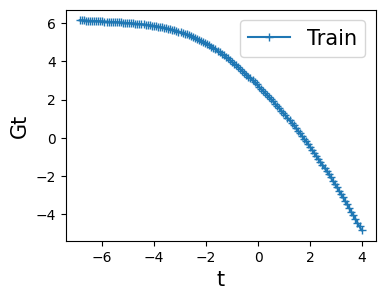

In [2]:
# plot the training data 

Gt=np.loadtxt('./Gt2.txt')
train_t  = np.log10(Gt[:,0]).reshape(-1, 1)
true_G   = np.log10(Gt[:,1]).reshape(-1, 1)

input_size = len(train_t)

# Plotting results
fig, ax=plt.subplots(1,1,figsize=(4,3))
ax.plot(train_t, true_G, '-+', label='Train')
ax.legend(fontsize=15)
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('Gt', fontsize=15)

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, phi_init=None, inv_taud_init=None):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            #nn.Tanh(),          # Ensures outputs are positive or zero
            
        )
        
        # Define learnable parameters mu and k
        self.raw_phi = nn.Parameter(
            torch.tensor(phi_init if phi_init is not None else [0.1] * 7, dtype=torch.float32)
        )
        self.raw_inv_taud = nn.Parameter(
            torch.tensor(inv_taud_init if inv_taud_init is not None else [1.0] * 7, dtype=torch.float32)
        )

    def forward(self, t):
        return self.net(t)
    
    
    def get_constrained_parameters(self):
         phi_raw      = F.relu(self.raw_phi) 
         phi = phi_raw / torch.sum(phi_raw)   
         inv_taud = torch.pow(10,(self.raw_inv_taud))  
        
         return phi, inv_taud

In [4]:
# Instantiate the model
#mphi_init     = [0.5, 0.3, 0.1, 0.05,  0.001,0.001,0.001]
#minv_taud_init = [5, 4, 2, 1, 0, -2, -3]

mphi_init     = [0.1, 0.1, 0.1, 0.1,  0.1,0.1,0.1]
#minv_taud_array = -np.linspace(min(train_t),max(train_t),num=7)
#minv_taud_array = -np.linspace(min(train_t), max(train_t), num=7)  # Precompute the values
#minv_taud_init = [-min(train_t),-min(train_t)-1, -min(train_t)-2,  max(train_t),  max(train_t),  max(train_t),  max(train_t)]
#minv_taud_init = [-min(train_t)[0], 4, 2, 1, 0, -2, -max(train_t)[0]]
minv_taud_init = [5, 4, 2, 1, 0, -2, -3]

print(minv_taud_init)

NN = NeuralNet(phi_init=mphi_init, inv_taud_init=minv_taud_init)
#= Optimizer
optimizer = optim.Adam(NN.parameters(), lr=1e-4)

[5, 4, 2, 1, 0, -2, -3]


In [5]:
# define the constant value 
G0    = torch.tensor(1.34e6, dtype=torch.float32) 
taue  = torch.tensor(7.0e-8, dtype=torch.float32)
Ncomp = 7  

# ODE system loss function

def mysystem_loss(t, y, model):
    t = torch.tensor(t, dtype=torch.float32).view(-1, 1)  # Ensure t is a tensor
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Ensure y is a tensor
      
    # Get model outputs
    u = model(t)  

    phi, inv_taud      =model.get_constrained_parameters()              # First Ncomp outputs are phi
    # =model.inv_taud                # Remaining Ncomp outputs are inv_taud
    
    # Compute exp(-inv_taud[i] * 10^t) for all i and t using broadcasting
    exp_terms = torch.exp(-inv_taud[:, None] * torch.pow(10, t.T))  # Shape: (7, input_size)

    # Compute the outer product of phi with itself
    phi_outer = phi[:, None] * phi[None, :]  # Shape: (7, 7)

    # Compute Gt using matrix multiplication and summation
    Gt = (phi_outer[:, :, None] * exp_terms[:, None, :] * exp_terms[None, :, :]).sum(dim=(0, 1))  # Shape: (input_size)

    # Reshape Gt2 to match your desired output shape
    Gt = Gt.view(-1, 1)  # Shape: (input_size, 1)

    Gt = Gt * G0
   
    # Compute the loss as the difference 
    loss_phys   = torch.log10(Gt) - y
    loss_cons1  = (torch.sum(phi)-1.0)**2
    
    loss_num    = u-y
    
    # Return the mean squared error
    total_loss =  5*torch.mean(loss_phys**2)+loss_cons1 +torch.mean(loss_num**2)
    
    #print(torch.mean(loss_num**2), torch.mean(loss_phys**2), loss_cons1)
    return total_loss, Gt.detach().cpu().numpy(), phi.detach().cpu().numpy(), inv_taud.detach().cpu().numpy()
    


63.80547332763672
3.522282361984253
2.5273263454437256
2.0152530670166016
1.720342755317688
1.5114247798919678
1.3436644077301025
1.1981077194213867
1.0666639804840088
0.9460300207138062
0.835369884967804
0.7348127365112305
0.6437669992446899
0.5611990690231323
0.48709118366241455
0.42114558815956116
0.36263307929039
0.31369099020957947
0.26978814601898193
0.22966358065605164
0.1949445754289627
0.169292613863945
0.14728809893131256
0.1258602887392044
0.11041729897260666
0.0982537642121315
0.08889437466859818
0.0818752720952034
0.07681738585233688
0.07331883162260056
0.07102641463279724
0.06959415227174759
0.06871259957551956
0.06816107034683228
0.06779754906892776
0.0675458088517189
0.06735078245401382
0.06720257550477982
0.06707528233528137
0.06696484237909317


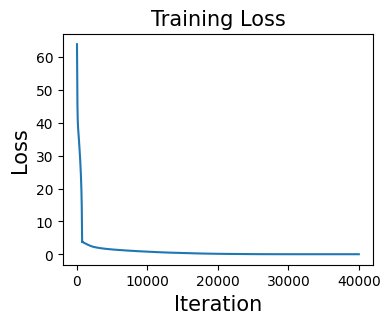

In [6]:
# Training data
train_loss_record = []
Gt_evolution = []
phi_evolution = []
inv_taud_evolution = []

# Training loop
for itr in range(40000):
    optimizer.zero_grad()
    train_loss, Gt_values, phi_values, inv_taud_values = mysystem_loss(train_t, true_G,  NN)
    train_loss.backward()
    optimizer.step()

    train_loss_record.append(train_loss.item())
    
    # Record the evolution of phi and inv_taud
    Gt_evolution.append(Gt_values)
    phi_evolution.append(phi_values)
    inv_taud_evolution.append(inv_taud_values)
    

    if itr % 1000 == 0:
        print(train_loss.item())

# Plot training loss
plt.figure(figsize=(4, 3))
plt.plot(train_loss_record)
plt.title("Training Loss", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.show()



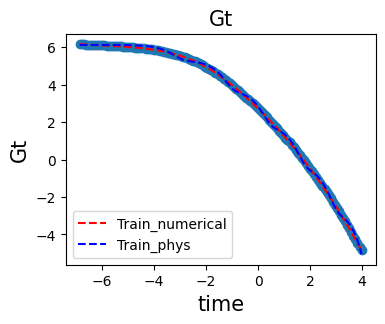

[6.1230153e-01 3.2324076e-01 5.6987476e-02 6.8277568e-03 6.0056965e-04
 0.0000000e+00 4.1876021e-05]
[2.3794719e+03 3.3809189e+01 1.2970487e+00 6.4434648e-02 4.1630324e-03
 1.1498759e-02 2.8998745e-04]


In [7]:
train_loss, Gt_values, phi_values, inv_taud_values = mysystem_loss(train_t, true_G,  NN)
t = torch.tensor(train_t, dtype=torch.float32).view(-1, 1)
G_num=NN(t).detach().numpy()

plt.figure(figsize=(4, 3))

plt.plot(train_t, G_num,'o')
plt.plot(train_t, true_G, '--r', label='Train_numerical')
plt.plot(train_t, np.log10(Gt_values), '--b', label='Train_phys')
plt.title("Gt", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.ylabel("Gt", fontsize=15)
plt.legend()
plt.show()

print(phi_values)
print(inv_taud_values)

In [8]:
# Plot evolution of phi values
'''
Gt_evolution=np.array(Gt_evolution)

plt.figure(figsize=(4, 3))
for i in range(2):
    plt.plot(train_t, np.log10(Gt_evolution[i, :]), label=f"step=[{i}]")
plt.plot(train_t, true_G, '--r', label='Train')
plt.title("Gt", fontsize=15)
plt.xlabel("time", fontsize=15)
plt.ylabel("Gt", fontsize=15)
plt.legend()
plt.show()


phi_evolution=np.array(phi_evolution)
plt.figure(figsize=(4, 3))
for i in range(Ncomp):
    plt.plot(phi_evolution[:, i], 'o', label=f"phi[{i}]")
plt.title("Evolution of Phi", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.ylabel("Phi Values", fontsize=15)
plt.legend()
plt.show()

inv_taud_evolution=np.array(inv_taud_evolution)
# Plot evolution of inv_taud values
plt.figure(figsize=(4, 3))
for i in range(Ncomp):
    plt.plot(inv_taud_evolution[:, i], 'o',label=f"inv_taud[{i}]")
plt.title("Evolution of Inv_taud", fontsize=15)
plt.xlabel("Iteration", fontsize=15)
plt.yscale('log')
plt.ylabel("Inv_taud Values", fontsize=15)
plt.legend()
plt.show()
'''

'\nGt_evolution=np.array(Gt_evolution)\n\nplt.figure(figsize=(4, 3))\nfor i in range(2):\n    plt.plot(train_t, np.log10(Gt_evolution[i, :]), label=f"step=[{i}]")\nplt.plot(train_t, true_G, \'--r\', label=\'Train\')\nplt.title("Gt", fontsize=15)\nplt.xlabel("time", fontsize=15)\nplt.ylabel("Gt", fontsize=15)\nplt.legend()\nplt.show()\n\n\nphi_evolution=np.array(phi_evolution)\nplt.figure(figsize=(4, 3))\nfor i in range(Ncomp):\n    plt.plot(phi_evolution[:, i], \'o\', label=f"phi[{i}]")\nplt.title("Evolution of Phi", fontsize=15)\nplt.xlabel("Iteration", fontsize=15)\nplt.ylabel("Phi Values", fontsize=15)\nplt.legend()\nplt.show()\n\ninv_taud_evolution=np.array(inv_taud_evolution)\n# Plot evolution of inv_taud values\nplt.figure(figsize=(4, 3))\nfor i in range(Ncomp):\n    plt.plot(inv_taud_evolution[:, i], \'o\',label=f"inv_taud[{i}]")\nplt.title("Evolution of Inv_taud", fontsize=15)\nplt.xlabel("Iteration", fontsize=15)\nplt.yscale(\'log\')\nplt.ylabel("Inv_taud Values", fontsize=15)